In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


# Data Science Project: *title*

by Millie Sohn, Markus Chu, Mhad Khan Sherwani and Sai Manas Pandrangi

## Introduction:

provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and fully describe the dataset that was used to answer the question

The gaming industry is expanding by the year, and efforts are made to study player's actions for a more targetted recruitment. To achieve this, researchers must predict what types of players are more likely to contribute to the games and determine which player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how these features differ between various player types. This science project aims to specifically answer whether play hours and the player's age predict whether a player will subscribe to the Minecraft newsletter or not. In order to answer this, we used data obtained from a Minecraft server which contain specific player information and whether they subscribe to the newsletter or not. The dataset, named "players", portrays a list of players and their data (7 variables, 196 observations): player's experience (amateur, beginner, pro, regular, veteran), subscription status (TRUE: subscribed to newsletter, FALSE: not subscribed), hashed Email that uniquely identifies each player, game play hours, player name, player gender, and player age. 
The dataset reveals that 144 players are subscribed, and 52 are not. Play hours range from 0 to 223.1 hours, and age range from 8 to 50 years old.


## Methods & Results

In [45]:
set.seed(1)

url_pl <- "https://raw.githubusercontent.com/takemil8088/ind-porject/refs/heads/main/players.csv"
players <- read_csv(url_pl) |>
select(subscribe, played_hours, Age) |>
filter(!is.na(subscribe), !is.na(played_hours), !is.na(Age)) |>
mutate(subscribe = as_factor(subscribe)) |>
rename(age = Age)
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17
TRUE,0.0,19
FALSE,0.0,21
TRUE,0.1,17


replace this with neat two short paragraphs:
- explain the variables we are gonna use (subscribe (logical): whether the player has subscribed to a game-related newsletter, played_hours (double): total hours the player spent playing, age (double): the player's age in years)
- potential issues (ex. Some players are much older or younger than the median age, Some players have especially high hours played, Some players did not provide all information (NA values))

### I believe we need some graphs on the dataset so the two below are what I had for the individual project. Feel free to change, replace, or add your own.

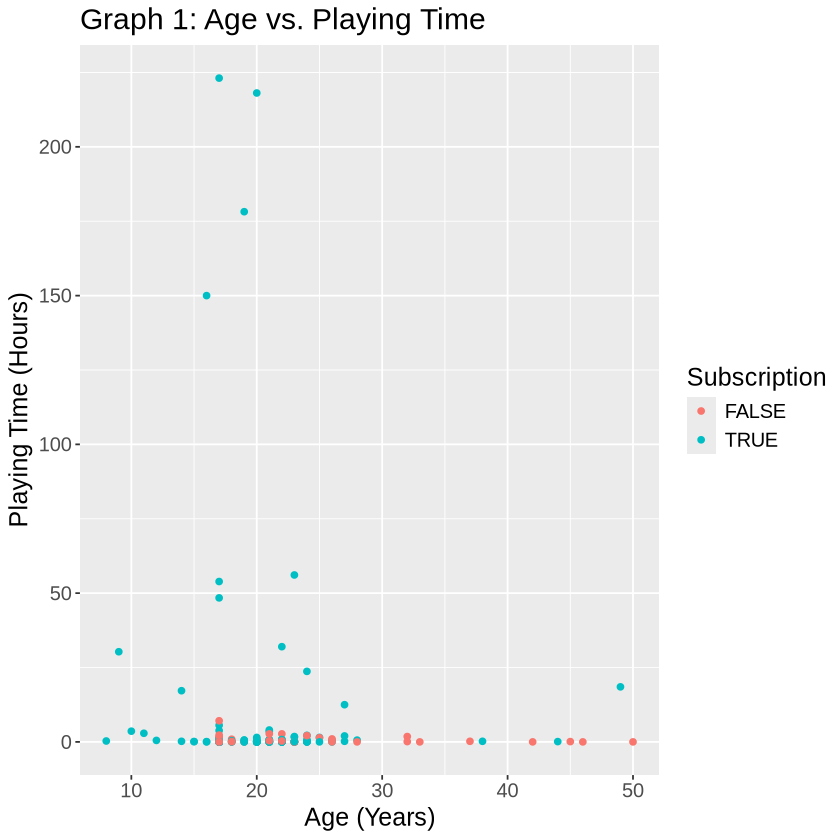

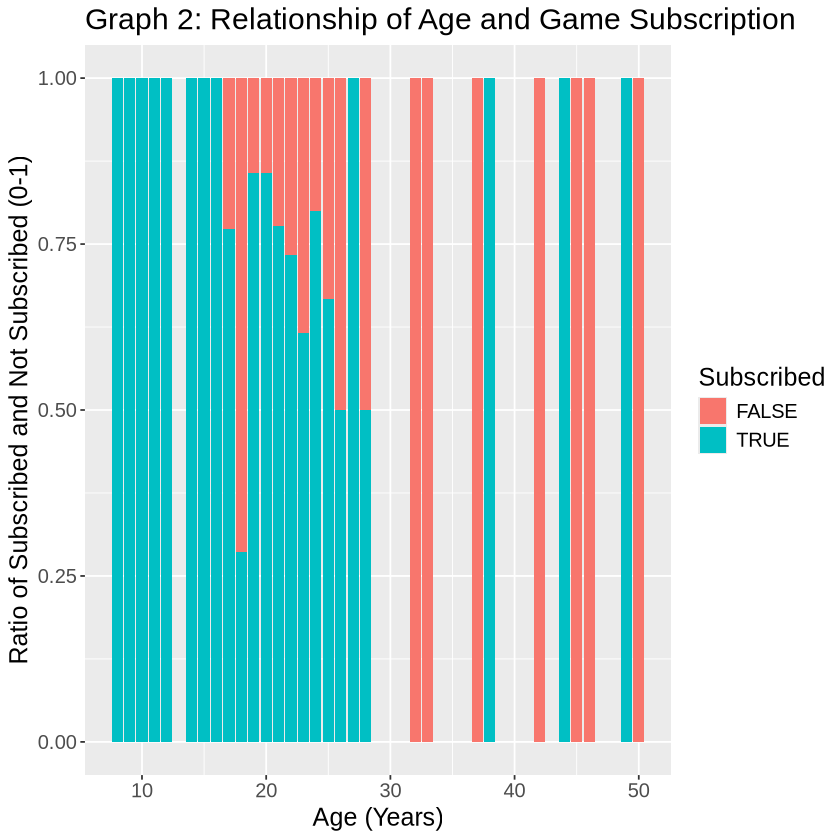

In [51]:
relation_played_hours_age <- players |>
    select(age, played_hours, subscribe) |>
    ggplot(aes(x = age, y = played_hours, colour = subscribe)) +
    geom_point() +
    labs(x = "Age (Years)",
         y = "Playing Time (Hours)",
         colour = "Subscription",
         title = "Graph 1: Age vs. Playing Time") +
    theme(text = element_text(size = 15))

relation_played_hours_age

age_subscribe_plot <- players |>
    select(age, subscribe) |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Age (Years)",
         y = "Ratio of Subscribed and Not Subscribed (0-1)",
         fill = "Subscribed",
         title = "Graph 2: Relationship of Age and Game Subscription") +
    theme(text = element_text(size = 15))

age_subscribe_plot

(describe the graphs, 1 and 2)

In [9]:
split <- initial_split(players, prop = 0.75, strata = subscribe)
train <- training(split)
test <- testing(split)

(why prop = 0.75?)

In [15]:
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

recipe <- recipe(subscribe ~ played_hours + age, data = train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

p_vfold <- vfold_cv(train, v = 10, strata = subscribe)

knn_results <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = p_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4552015,10,0.035973276,Preprocessor1_Model01
6,accuracy,binary,0.5457509,10,0.032969133,Preprocessor1_Model02
11,accuracy,binary,0.5923443,10,0.035353097,Preprocessor1_Model03
16,accuracy,binary,0.7050183,10,0.026542896,Preprocessor1_Model04
21,accuracy,binary,0.7383516,10,0.007075921,Preprocessor1_Model05
26,accuracy,binary,0.7445421,10,0.010545974,Preprocessor1_Model06
31,accuracy,binary,0.7383516,10,0.007075921,Preprocessor1_Model07
36,accuracy,binary,0.7312088,10,0.005090213,Preprocessor1_Model08
41,accuracy,binary,0.7312088,10,0.005090213,Preprocessor1_Model09


(does counting by = 5 instead of by = 1 make a difference? how so and why choose by = 5? Going to compare using v = 10 and v = 5 later so don't mention why we use v = 10 yet.)

[1] 26

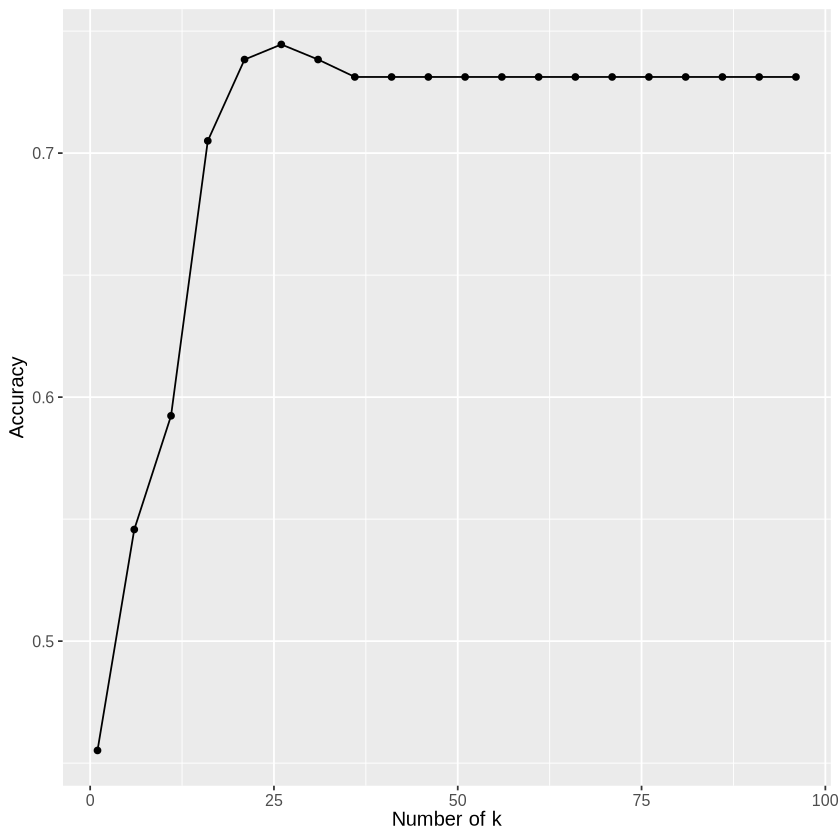

In [44]:
best_k_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    xlab("Number of k") +
    ylab("Accuracy") +
    theme(text = element_text(size = 12))

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k_plot
best_k

(short sentence or two on what K = 26 means, and talk about plot!)

In [30]:
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

vfold_5 <- vfold_cv(train, v = 5, strata = subscribe)

vfold_5_fit <- workflow() |>
    add_recipe(recipe) |>
    add_model(knn_spec_new) |>
    fit_resamples(resamples = vfold_5)

vfold_5_metrics <- vfold_5_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy")

vfold_5_metrics

vfold_10_fit <- workflow() |>
    add_recipe(recipe) |>
    add_model(knn_spec_new) |>
    fit_resamples(resamples = p_vfold)

vfold_10_metrics <- vfold_10_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy")

vfold_10_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7454351,5,0.01908163,Preprocessor1_Model1


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7445421,10,0.01054597,Preprocessor1_Model1


(was there a difference using v=5 and v=10? if not, why and what does this say? We will work with v=10.)

In [42]:
knn_fit <- workflow() |>
    add_recipe(recipe) |>
    add_model(knn_spec_new) |>
    fit(data = train)

p_predictions <- predict(knn_fit, test) |>
  bind_cols(test)

prediction_accuracy <- p_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

prediction_precision <- p_predictions|>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")

prediction_recall <- p_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")

# prediction_labels <- p_predictions |> 
#    pull(subscribe) |> 
#    levels()

prediction_accuracy
prediction_precision
prediction_recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7346939


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,1


(what does the prediction accuracy, recall and precision say?)

## Discussion:
1. What was found
2. Is this what was expected to find
3. Discuss what impact could such findings have
4. What future questions could this lead to

## References: optional
(Apa citation I think)